In [12]:
# Cell 1: Imports
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from data_generation import load_cicids_data
from feature_engineering import clean_cicids_data, engineer_features_cicids, normalize_data
from model_training import train_model, evaluate_model, analyze_errors_task3
from visualization import plot_distributions, plot_confusion_matrix, plot_roc_curve, plot_betas, plot_correlation_matrix, plot_learning_curve_manual

In [13]:
# Cell 2: Konfiguracja ścieżki
DATA_DIR = os.path.join('..', 'data', 'CICIDS2017')

In [14]:
# Cell 3: Wczytywanie danych
try:
    print("Wczytywanie surowych danych CICIDS2017...")
    df_raw = load_cicids_data(DATA_DIR, sample_size=50000)
    print(f"Wczytano {len(df_raw)} wierszy.")
except FileNotFoundError as e:
    print(e)
    print("Upewnij się, że pliki CSV znajdują się w folderze data/CICIDS2017/")

Wczytywanie surowych danych CICIDS2017...
Wczytywanie: Monday-WorkingHours.pcap_ISCX.csv
Wczytywanie: Friday-WorkingHours-Afternoon-DDoS.pcap_ISCX.csv
Wczytywanie: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Wczytano 150000 wierszy.


Czyszczenie danych...
Tworzenie cech...


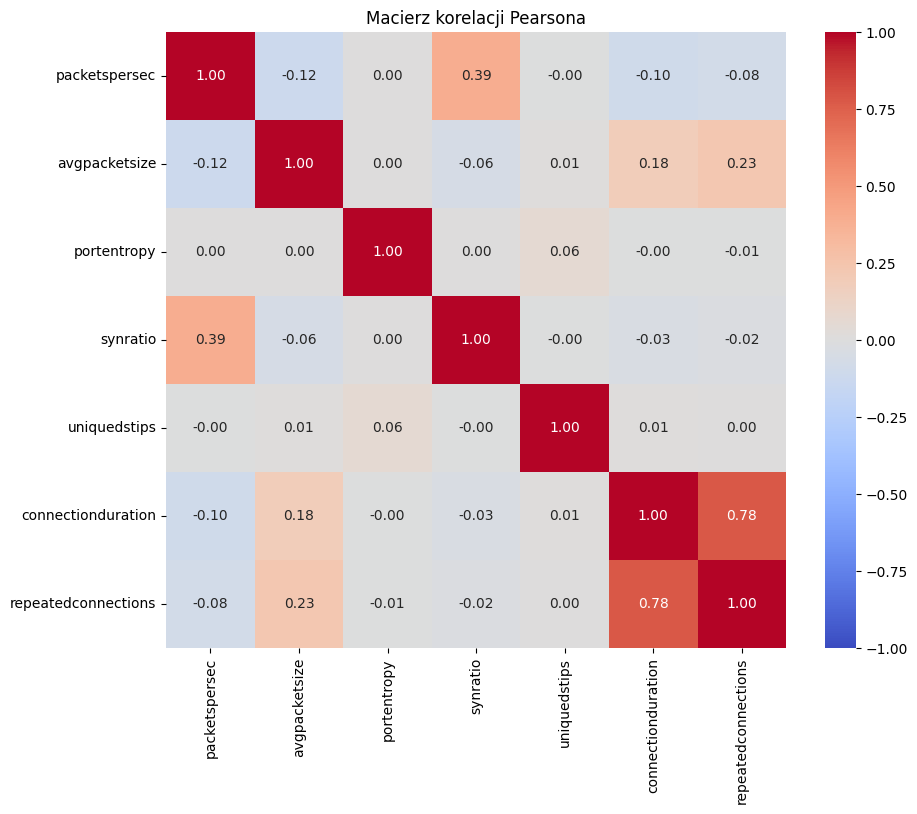

Generowanie rozkładów gęstości...


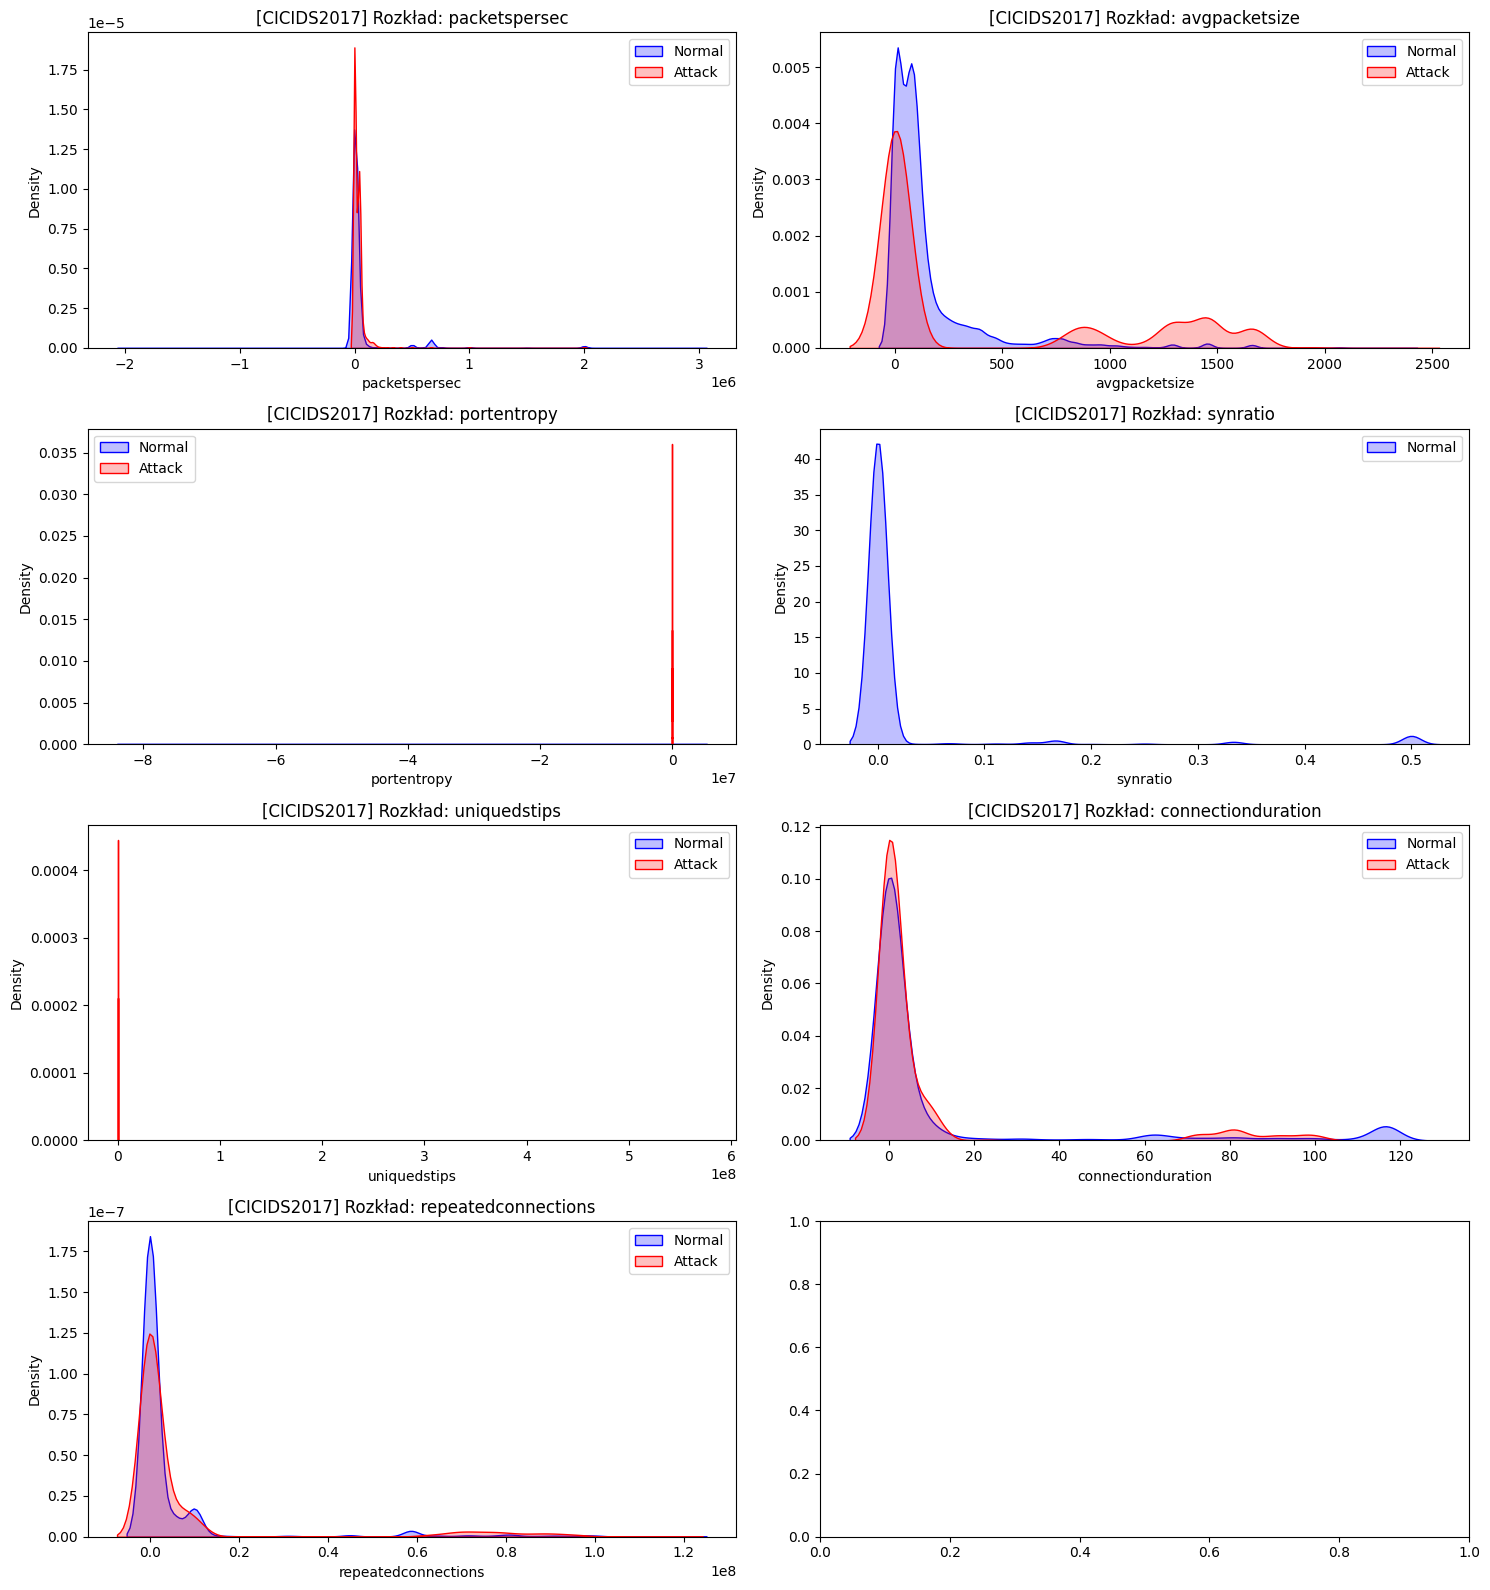

Generowanie macierzy korelacji...


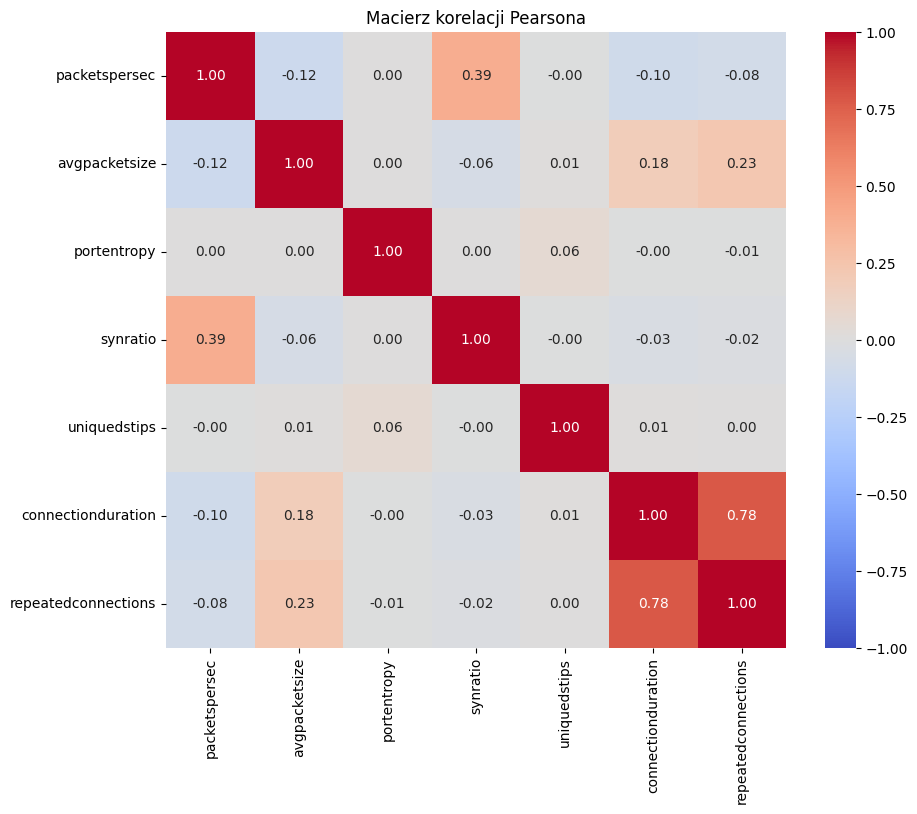

In [ ]:
# Cell 4: Przetwarzanie i Inżynieria Cech
print("Czyszczenie danych...")
df_clean = clean_cicids_data(df_raw)
print("Tworzenie cech...")
X_df, y, labels_raw = engineer_features_cicids(df_clean)
feature_names = X_df.columns.tolist()

plot_correlation_matrix(X_df, feature_names)

# 1. Przygotowanie ramki do wizualizacji (łączenie cech z etykietą)
df_vis = X_df.copy()
df_vis['Target'] = y.values  # Dodajemy kolumnę Target, bo plot_distributions jej wymaga

# 2. Wyświetlenie rozkładów gęstości dla każdej cechy
print("Generowanie rozkładów gęstości...")
plot_distributions(df_vis, feature_names, title_prefix='[CICIDS2017]')

# 3. Wyświetlenie macierzy korelacji między cechami
print("Generowanie macierzy korelacji...")
plot_correlation_matrix(df_vis, feature_names)

In [16]:
# Cell 5: Podział na Train/Val/Test (60/20/20)
X_train_val, X_test_raw, y_train_val, y_test = train_test_split(X_df.values, y.values, test_size=0.2, stratify=y, random_state=42)
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

In [17]:
# Cell 6: Normalizacja
X_train, X_test, X_val, scaler = normalize_data(X_train_raw, X_test_raw, X_val_raw)

In [18]:
# Cell 7: Trenowanie (Balanced)
print("Trenowanie modelu (Balanced)...")
model = train_model(X_train, y_train, class_weight='balanced')

Trenowanie modelu (Balanced)...


In [19]:
# Cell 8: Ewaluacja
metrics, y_pred, y_prob = evaluate_model(model, X_test, y_test)
print(f"Accuracy:  {metrics['Accuracy']:.4f}")
print(f"Recall:    {metrics['Recall']:.4f}")
print(f"AUC:       {metrics['AUC']:.4f}")

Accuracy:  0.8534
Recall:    0.9840
AUC:       0.8918


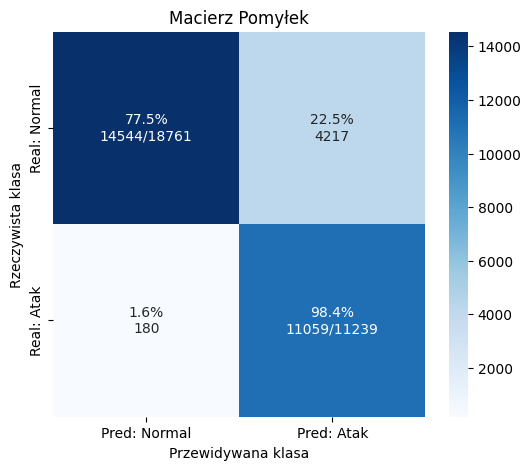

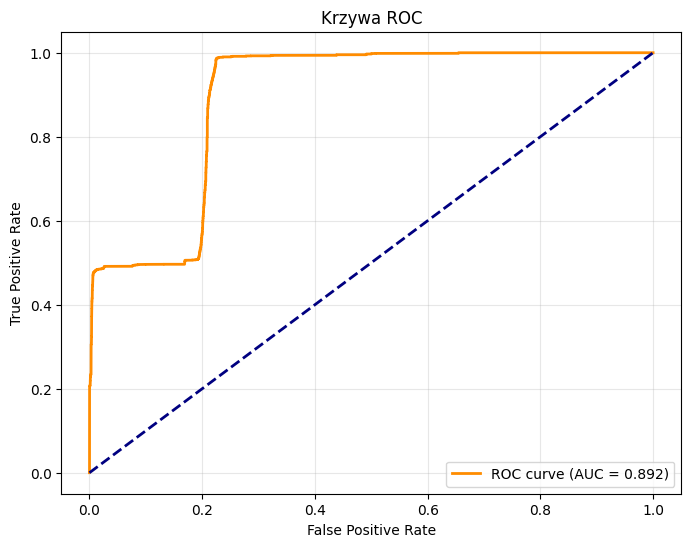

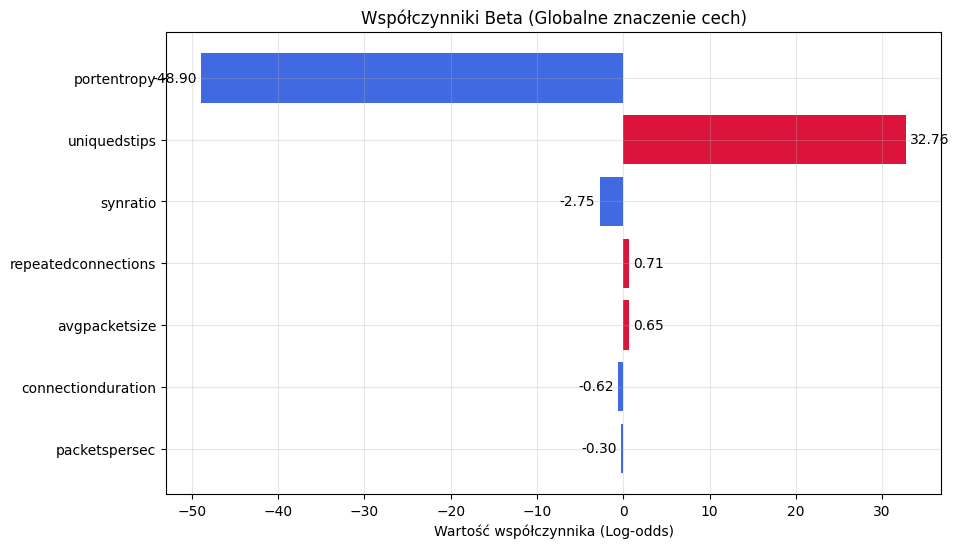

In [20]:
# Cell 9: Wizualizacja
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(metrics)
plot_betas(model, feature_names)

Generowanie krzywej uczenia...


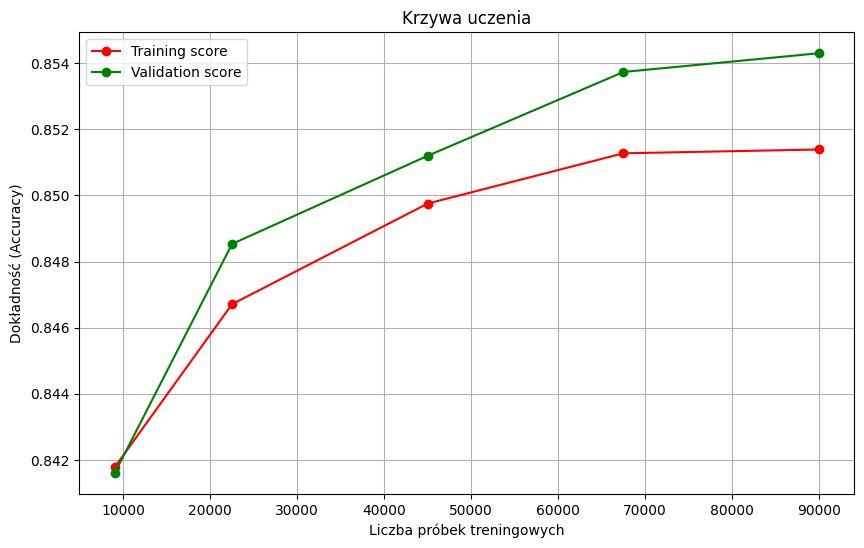

In [21]:
# Cell 9b: Generowanie i rysowanie krzywej uczenia
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

train_sizes_pct = [0.1, 0.25, 0.5, 0.75, 1.0]
train_scores = []
val_scores = []
train_sizes_abs = []

print("Generowanie krzywej uczenia...")
for pct in train_sizes_pct:
    # Bierzemy podzbiór danych treningowych
    n_samples = int(pct * len(X_train))
    train_sizes_abs.append(n_samples)
    
    X_sub = X_train[:n_samples]
    y_sub = y_train[:n_samples]
    
    # Trenujemy tymczasowy model
    model_temp = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    model_temp.fit(X_sub, y_sub)
    
    # Zapisujemy wyniki
    train_scores.append(accuracy_score(y_sub, model_temp.predict(X_sub)))
    val_scores.append(accuracy_score(y_val, model_temp.predict(X_val)))

plot_learning_curve_manual(train_sizes_abs, train_scores, val_scores)

In [22]:
# Cell 10: Analiza Błędów
fn_samples, fp_samples, _, _ = analyze_errors_task3(X_test_raw, y_test, y_pred, y_prob, feature_names)

print("\nPrzykładowe False Negatives (Atak uznany za normę):")
display(fn_samples.head())

print("\nPrzykładowe False Positives (Norma uznana za atak):")
display(fp_samples.head())


Przykładowe False Negatives (Atak uznany za normę):


,packetspersec,avgpacketsize,portentropy,synratio,uniquedstips,connectionduration,repeatedconnections
68,250000.000000,3.000000,20.0,0.0,6.0,0.000008,0.0
345,200000.000000,5.000000,20.0,0.0,6.0,0.000010,0.0
366,19.655075,1290.333333,200.0,0.0,11595.0,0.457897,456311.0
475,250000.000000,5.000000,20.0,0.0,6.0,0.000008,0.0
584,333333.333300,3.000000,20.0,0.0,6.0,0.000006,0.0



Przykładowe False Positives (Norma uznana za atak):


,packetspersec,avgpacketsize,portentropy,synratio,uniquedstips,connectionduration,repeatedconnections
0,86956.521739,9.0,20.0,0.0,6.0,0.000023,0.0
2,18691.588790,9.0,20.0,0.0,6.0,0.000107,0.0
8,42553.191489,9.0,20.0,0.0,6.0,0.000047,0.0
19,26315.789474,9.0,20.0,0.0,6.0,0.000076,0.0
24,666666.666667,9.0,0.0,0.0,0.0,0.000003,3.0
